In [ ]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

#Librerias para guardar archivos
import joblib

Función para analizar el dataset

In [10]:
def analyze_image_dataset(dataset_path):
    """
    Analiza un dataset de imágenes organizadas en carpetas por clase.
    
    Parameters:
    -----------
    dataset_path : str
        Ruta al directorio principal que contiene las carpetas de cada clase
    
    Returns:
    --------
    dict : Diccionario con estadísticas del dataset
    pd.DataFrame : DataFrame con rutas de imágenes y sus clases
    """
    
    # Extensiones de imagen válidas
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    
    # Diccionario para almacenar información
    dataset_info = {
        'classes': [],
        'images_per_class': {},
        'total_images': 0,
        'file_extensions': set()
    }
    
    # Lista para crear el DataFrame
    data_rows = []
    
    # Verificar si el path existe
    if not os.path.exists(dataset_path):
        print(f" Error: El directorio {dataset_path} no existe")
        return None, None
    
    # Listar todas las carpetas (clases)
    classes = [d for d in os.listdir(dataset_path) 
               if os.path.isdir(os.path.join(dataset_path, d))]
    
    
    classes.sort()  # Ordenar alfabéticamente
    dataset_info['classes'] = classes
    
    print("="*80)
    print(" ANÁLISIS DEL DATASET DE ENFERMEDADES DE CEBOLLA LARGA")
    print("="*80)
    print(f"\n Directorio del dataset: {dataset_path}")
    print(f" Total de clases encontradas: {len(classes)}")
    print("\n" + "-"*80)
    print(" CONTEO DE IMÁGENES POR CLASE:")
    print("-"*80)
    
    # Analizar cada clase
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        image_count = 0
        
        # Contar imágenes en la carpeta
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            if os.path.isfile(file_path):
                # Verificar si es una imagen
                file_extension = os.path.splitext(file)[1].lower()
                if file_extension in valid_extensions:
                    image_count += 1
                    dataset_info['file_extensions'].add(file_extension)
                    
                    # Agregar a la lista para el DataFrame
                    data_rows.append({
                        'image_path': file_path,
                        'class': class_name,
                        'filename': file,
                        'extension': file_extension
                    })
        
        dataset_info['images_per_class'][class_name] = image_count
        dataset_info['total_images'] += image_count
        
        # Imprimir información de cada clase
        print(f"  {class_name:30s} : {image_count:5d} imágenes")
    
    print("-"*80)
    print(f"\n ESTADÍSTICAS GENERALES:")
    print("-"*80)
    print(f"  • Total de imágenes: {dataset_info['total_images']}")
    print(f"  • Número de clases: {len(classes)}")
    print(f"  • Promedio de imágenes por clase: {dataset_info['total_images']/len(classes):.2f}")
    
    # Encontrar clases con más y menos imágenes
    if dataset_info['images_per_class']:
        max_class = max(dataset_info['images_per_class'].items(), key=lambda x: x[1])
        min_class = min(dataset_info['images_per_class'].items(), key=lambda x: x[1])
        print(f"  • Clase con más imágenes: {max_class[0]} ({max_class[1]} imágenes)")
        print(f"  • Clase con menos imágenes: {min_class[0]} ({min_class[1]} imágenes)")
    
    print(f"  • Extensiones encontradas: {', '.join(dataset_info['file_extensions'])}")
    
    # Crear DataFrame
    df = pd.DataFrame(data_rows)
    
    # Verificar si hay desbalance significativo
    if dataset_info['images_per_class']:
        values = list(dataset_info['images_per_class'].values())
        if values:
            imbalance_ratio = max(values) / min(values) if min(values) > 0 else float('inf')
            print(f"\n  ANÁLISIS DE BALANCE:")
            print("-"*80)
            print(f"  • Ratio de desbalance: {imbalance_ratio:.2f}x")
            if imbalance_ratio > 2:
                print("  •  Dataset desbalanceado")
            else:
                print("  •  Dataset relativamente balanceado")
    
    print("\n" + "="*80)
    
    return dataset_info, df

Función para crear un CSV con con la información del dataset

In [3]:
def create_dataset_csv(df, output_path='dataset_info.csv', simplified=True):
    """
    Crea un archivo CSV con la información del dataset.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con la información completa del dataset
    output_path : str
        Ruta donde se guardará el archivo CSV
    simplified : bool
        Si True, solo guarda ruta de imagen y clase. Si False, guarda toda la info.
    """
    
    if df is None or df.empty:
        print(" No hay datos para guardar en CSV")
        return None
    
    if simplified:
        # Crear CSV simplificado con solo ruta y clase
        df_simplified = df[['image_path', 'class']].copy()
        df_simplified.to_csv(output_path, index=False)
        print(f"\n Archivo CSV creado: {output_path}")
        print(f"   Columnas: image_path, class")
        print(f"   Total de registros: {len(df_simplified)}")
    else:
        # Guardar toda la información
        df.to_csv(output_path, index=False)
        print(f"\n Archivo CSV completo creado: {output_path}")
        print(f"   Columnas: {', '.join(df.columns)}")
        print(f"   Total de registros: {len(df)}")
    
    return output_path

Función para visualizar la distribución del Dataset

In [14]:
def visualize_class_distribution(dataset_info, save_path='class_distribution.png'):
    """
    Crea una visualización de la distribución de clases.
    
    Parameters:
    -----------
    dataset_info : dict
        Diccionario con la información del dataset
    save_path : str
        Ruta donde se guardará la imagen
    """
    
    # Preparar datos para el gráfico
    classes = list(dataset_info['images_per_class'].keys())
    counts = list(dataset_info['images_per_class'].values())
    
    # Crear la figura
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Gráfico de barras
    bars = ax1.bar(range(len(classes)), counts, color='steelblue', alpha=0.8)
    ax1.set_xticks(range(len(classes)))
    ax1.set_xticklabels(classes, rotation=45, ha='right')
    ax1.set_xlabel('Clase de Enfermedad')
    ax1.set_ylabel('Número de Imágenes')
    ax1.set_title('Distribución de Imágenes por Clase de Enfermedad')
    ax1.grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom')
    
    # Línea horizontal para el promedio
    avg_count = sum(counts) / len(counts)
    ax1.axhline(y=avg_count, color='red', linestyle='--', alpha=0.7, 
                label=f'Promedio: {avg_count:.1f}')
    ax1.legend()
    
    # Gráfico circular (pie chart)
    colors = plt.cm.Set3(range(len(classes)))
    explode = [0.05] * len(classes)  # Separar ligeramente cada porción
    
    # Solo mostrar porcentajes en las porciones grandes
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 5 else ''
    
    ax2.pie(counts, labels=classes, colors=colors, autopct=autopct_format,
            startangle=90, explode=explode)
    ax2.set_title('Proporción de Imágenes por Clase')
    
    plt.tight_layout()
    plt.show()
    
    return save_path

Función para crear un CSV con los datos de pruebay entrenamiento

In [5]:
def split_dataset_info(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, 
                       stratified=True, random_seed=42):
    """
    Divide el dataset en conjuntos de entrenamiento, validación y prueba.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con la información del dataset
    train_ratio : float
        Proporción para entrenamiento
    val_ratio : float
        Proporción para validación
    test_ratio : float
        Proporción para prueba
    stratified : bool
        Si True, mantiene la proporción de clases en cada conjunto
    random_seed : int
        Semilla para reproducibilidad
    """
    
    from sklearn.model_selection import train_test_split
    
    if df is None or df.empty:
        print(" No hay datos para dividir")
        return None, None, None
    
    # Verificar que las proporciones sumen 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.001, \
           "Las proporciones deben sumar 1.0"
    
    # Primera división: train+val vs test
    if stratified:
        X_temp, X_test, y_temp, y_test = train_test_split(
            df[['image_path']], df['class'],
            test_size=test_ratio,
            stratify=df['class'],
            random_state=random_seed
        )
    else:
        X_temp, X_test, y_temp, y_test = train_test_split(
            df[['image_path']], df['class'],
            test_size=test_ratio,
            random_state=random_seed
        )
    
    # Segunda división: train vs val
    val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
    
    if stratified:
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_ratio_adjusted,
            stratify=y_temp,
            random_state=random_seed
        )
    else:
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_ratio_adjusted,
            random_state=random_seed
        )
    
    # Crear DataFrames para cada conjunto
    train_df = pd.DataFrame({'image_path': X_train['image_path'].values, 'class': y_train.values})
    val_df = pd.DataFrame({'image_path': X_val['image_path'].values, 'class': y_val.values})
    test_df = pd.DataFrame({'image_path': X_test['image_path'].values, 'class': y_test.values})
    
    print("\nDIVISIÓN DEL DATASET:")
    print("-"*80)
    print(f"  • Conjunto de entrenamiento: {len(train_df)} imágenes ({train_ratio*100:.1f}%)")
    print(f"  • Conjunto de validación: {len(val_df)} imágenes ({val_ratio*100:.1f}%)")
    print(f"  • Conjunto de prueba: {len(test_df)} imágenes ({test_ratio*100:.1f}%)")
    print(f"  • Estratificado: {'Sí' if stratified else 'No'}")
    
    # Guardar los conjuntos en archivos CSV separados
    train_df.to_csv('train_dataset.csv', index=False)
    val_df.to_csv('val_dataset.csv', index=False)
    test_df.to_csv('test_dataset.csv', index=False)
    
    print("\nArchivos CSV creados:")
    print("   • train_dataset.csv")
    print("   • val_dataset.csv")
    print("   • test_dataset.csv")
    
    return train_df, val_df, test_df

Flujo Principal

In [8]:
#Path del dataset
DATASET_PATH = "Onion_Desease_Dataset\onion datasets"

In [11]:
# 1. Analizar el dataset
dataset_info, df = analyze_image_dataset(DATASET_PATH)

 ANÁLISIS DEL DATASET DE ENFERMEDADES DE CEBOLLA LARGA

 Directorio del dataset: Onion_Desease_Dataset\onion datasets
 Total de clases encontradas: 15

--------------------------------------------------------------------------------
 CONTEO DE IMÁGENES POR CLASE:
--------------------------------------------------------------------------------
  Alternaria_D                   :   830 imágenes
  Botrytis Leaf Blight           :   289 imágenes
  Bulb Rot                       :     7 imágenes
  Bulb_blight-D                  :   394 imágenes
  Caterpillar-P                  :  1558 imágenes
  Downy mildew                   :    37 imágenes
  Fusarium-D                     :  1276 imágenes
  Healthy leaves                 :  3440 imágenes
  Iris yellow virus_augment      :  1899 imágenes
  Purple blotch                  :   847 imágenes
  Rust                           :   213 imágenes
  Virosis-D                      :   512 imágenes
  Xanthomonas Leaf Blight        :   189 imágenes
  oni

In [12]:
# 2. Crear archivo CSV con rutas y clases
csv_path = create_dataset_csv(df, 'onion_dataset.csv', simplified=True)


 Archivo CSV creado: onion_dataset.csv
   Columnas: image_path, class
   Total de registros: 13229


In [13]:
# 3. Crear archivo CSV completo con toda la información
csv_full_path = create_dataset_csv(df, 'onion_dataset_full.csv', simplified=False)


 Archivo CSV completo creado: onion_dataset_full.csv
   Columnas: image_path, class, filename, extension
   Total de registros: 13229


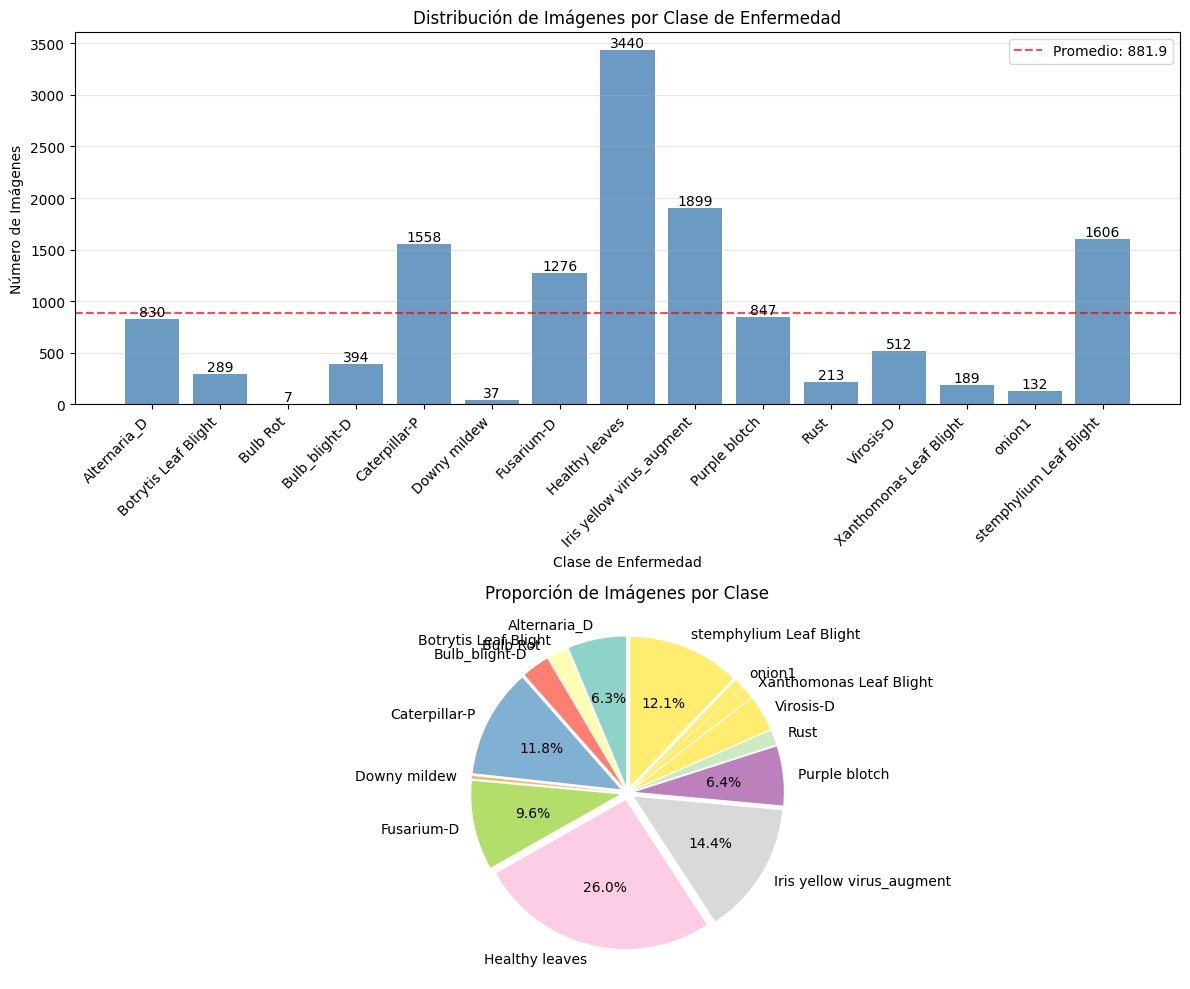

'class_distribution.png'

In [15]:
# 4. Visualizar la distribución de las clases
visualize_class_distribution(dataset_info, 'class_distribution.png')

In [16]:
# 5. Dividir el dataset en train/val/test
train_df, val_df, test_df = split_dataset_info(df)


DIVISIÓN DEL DATASET:
--------------------------------------------------------------------------------
  • Conjunto de entrenamiento: 9259 imágenes (70.0%)
  • Conjunto de validación: 1985 imágenes (15.0%)
  • Conjunto de prueba: 1985 imágenes (15.0%)
  • Estratificado: Sí

Archivos CSV creados:
   • train_dataset.csv
   • val_dataset.csv
   • test_dataset.csv
